In [3]:
import torch
import numpy as np
import rioxarray as rxr
import matplotlib.pyplot as plt
from terratorch import FULL_MODEL_REGISTRY
from plotting_utils import plot_s2

# Import to register models. Remove after pr in TerraTorch
import terracodec.terracodec_register

# Select device
if torch.cuda.is_available():
   device = 'cuda'    
elif torch.backends.mps.is_available():
   device = 'mps'
else:
    device = 'cpu'

In [4]:
# We load three (low, medium and high) compression settings of the ELIC model

model_low = FULL_MODEL_REGISTRY.build('terracodec_v1_elic_s2l2a', pretrained=True, compression="lambda-2")
model_mid = FULL_MODEL_REGISTRY.build('terracodec_v1_elic_s2l2a', pretrained=True, compression=10) # Different way to specify compression (lambda value directly)
model_high = FULL_MODEL_REGISTRY.build('terracodec_v1_elic_s2l2a', pretrained=True, compression=39) # Invalid lambda value will be mapped to closest available (lambda=40, in this case)

_ = model_low.to(device)
_ = model_mid.to(device)
_ = model_high.to(device)

INFO:httpx:HTTP Request: HEAD https://huggingface.co/embed2scale/TerraCodec-1.0-ELIC-S2L2A/resolve/main/config_lambda-2.yaml "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/embed2scale/TerraCodec-1.0-ELIC-S2L2A/resolve/main/config_lambda-2.yaml "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/embed2scale/TerraCodec-1.0-ELIC-S2L2A/resolve/main/TerraCodec_v1_ELIC_S2L2A_lambda-2.pt "HTTP/1.1 302 Found"
INFO:httpx:HTTP Request: GET https://huggingface.co/api/models/embed2scale/TerraCodec-1.0-ELIC-S2L2A/xet-read-token/ec57d812ad02e3fce16f56c8c74cd5c9b47e69e0 "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/embed2scale/TerraCodec-1.0-ELIC-S2L2A/resolve/main/config_lambda-10.yaml "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET https://huggingface.co/embed2scale/TerraCodec-1.0-ELIC-S2L2A/resolve/main/config_lambda-10.yaml "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: HEAD https://huggingface.co/embed2scale/TerraCodec-1.0-ELIC-S2L2A/

In [5]:
# Load a single images
examples = [
    '../examples/S2L2A_images/ssl4eos12_val_0080717_0.tif',
    '../examples/S2L2A_images/ssl4eos12_val_0121563_0.tif',
    '../examples/S2L2A_images/ssl4eos12_val_0173706_0.tif',
    '../examples/S2L2A_images/ssl4eos12_val_0181476_0.tif',
    '../examples/S2L2A_images/ssl4eos12_val_0193833_0.tif',
]

# Load examples
data = np.stack([rxr.open_rasterio(path).values for path in examples])

# Convert to shape [B, C, 256, 256]
data = torch.tensor(data[:, :, :256, :256])
data.shape

torch.Size([5, 12, 256, 256])

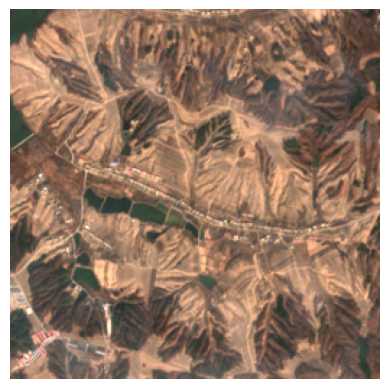

In [6]:
# Visualize S-2 L2A input example as RGB
plot_s2(data[0])

In [7]:
# Normalization stats
mean = torch.tensor([
    793.243, 924.863, 1184.553, 1340.936, 1671.402, 2240.082,
    2468.412, 2563.243, 2627.704, 2711.071, 2416.714, 1849.625
])
std = torch.tensor([
    1160.144, 1201.092, 1219.943, 1397.225, 1400.035, 1373.136,
    1429.170, 1485.025, 1447.836, 1652.703, 1471.002, 1365.307
])

# Helpers
def normalize(x, mean, std):
    return (x - mean[None, :, None, None]) / std[None, :, None, None]

def denormalize(x, mean, std):
    return x * std[None, :, None, None] + mean[None, :, None, None]

In [8]:
# Normalize and move to device
inputs = normalize(data, mean, std).to(device)

# Run forward pass to encode & decode 
with torch.no_grad():
    reconstruction = model_high(inputs)

# Denormalize output
reconstruction = denormalize(reconstruction.cpu(), mean, std)

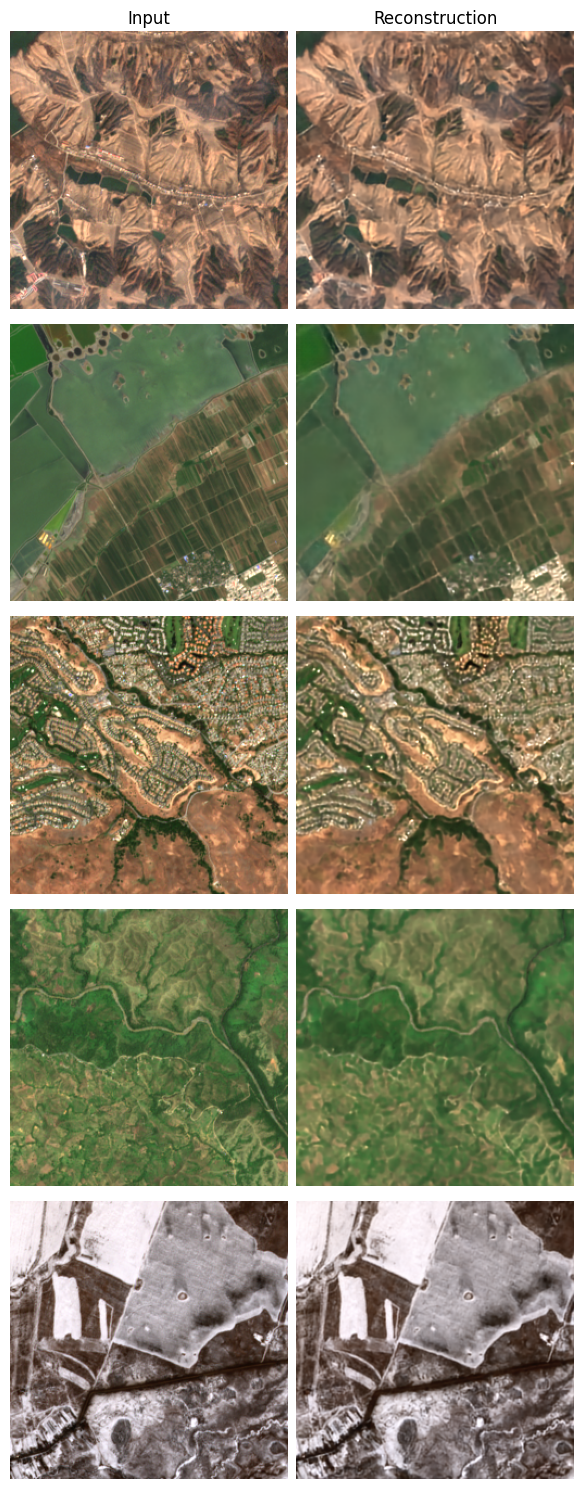

In [9]:
num_samples = len(data)
fig, ax = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

for i in range(num_samples):
    plot_s2(data[i], ax=ax[i, 0])           # Original
    plot_s2(reconstruction[i], ax=ax[i, 1]) # Reconstructed

ax[0, 0].set_title("Input")
ax[0, 1].set_title("Reconstruction")

plt.tight_layout()
plt.show()

In [10]:
# Run compress, decompress to get bits per encoded image
models = [model_low, model_mid, model_high]

# Take a single sample (keep batch dim)
sample_image = inputs[0].unsqueeze(0)

bits = []
reconstructions = []

with torch.no_grad():
    for model in models:
        # Encode
        compressed = model.compress(sample_image)
        bits.append(compressed["bits"])

        # Decode
        reconstruction = model.decompress(**compressed)
        reconstructions.append(reconstruction)


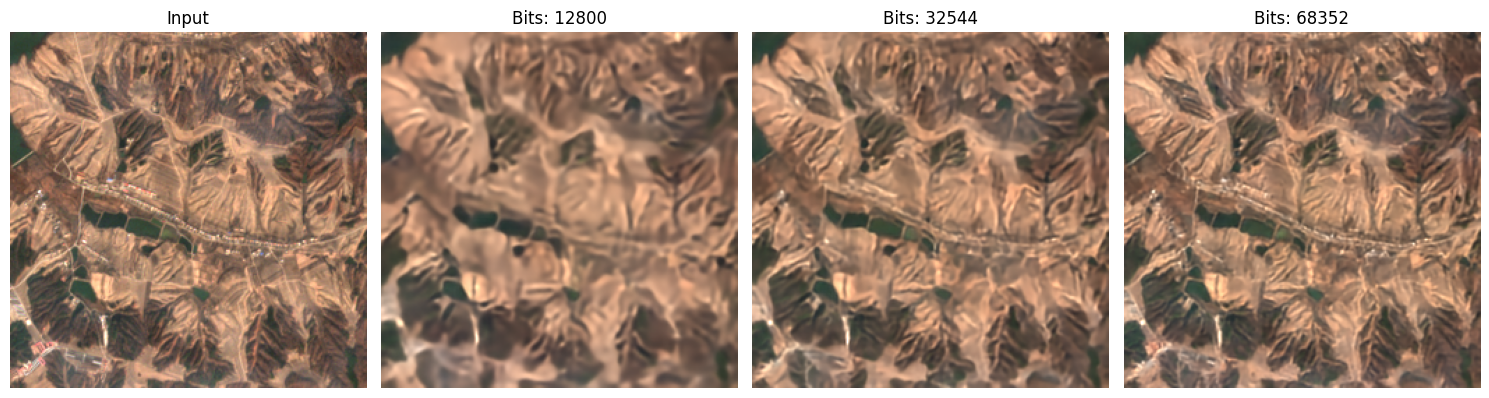

In [11]:
num_models = len(reconstructions)
fig, ax = plt.subplots(1, num_models + 1, figsize=(15, 5))

def denormalize(x, mean, std):
    x = x.cpu()
    return x * std[None, :, None, None] + mean[None, :, None, None]

# Plot input
sample_image_vis = denormalize(sample_image, mean, std)
plot_s2(sample_image_vis, ax=ax[0])
ax[0].set_title("Input")

# Plot reconstructions
for i, (reconstruction, bit_val) in enumerate(zip(reconstructions, bits), start=1):
    reconstruction_vis = denormalize(reconstruction, mean, std)
    plot_s2(reconstruction_vis, ax=ax[i])
    ax[i].set_title("Bits: " + str(bit_val))

plt.tight_layout()
plt.show()